In [1]:
import logging
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pathlib import Path
from utils import tools, metrics
from modules.cae_base_module import CAEBaseModule
from models import supported_models
from datasets import supported_datamodules

plt.style.use('seaborn')

In [5]:
# Import configurations and paths to logged models
root = Path.cwd() / '..'
log_path = root / 'logs' / 'NoveltyMNISTDataModule'
paths_to_archived_models = Path(log_path).glob('**/*CAE*/archive*')

module_catalog = {}

for pth in paths_to_archived_models:
    config = tools.load_config(pth / 'configuration.yaml', silent=True)
    model_type = pth.parent.name
    model_name = pth.name
    model_path = next(iter((pth / 'checkpoints').glob('val_loss*')))
    
    datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
        **config['data-parameters'])
    datamodule.setup('test')

    model = supported_models[config['experiment-parameters']['model']](
        in_chans=datamodule.data_shape[0])

    module = CAEBaseModule(model, **config['module-parameters'])
    
    # Load the state_dict into the module architecture
    checkpoint = torch.load(model_path)
    module.load_state_dict(checkpoint['state_dict'])
    
    if model_type not in module_catalog:
        module_catalog[model_type] = {}
    module_catalog[model_type][model_name] = module

In [6]:
# Collect scores and labels for all models into a catalog
scores = pd.DataFrame()
labels = pd.DataFrame()
for model_type, model_variants in module_catalog.items():
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'{short_name}\n-----')
        module.model.eval()  # Freeze dropout and batch normalization parameters
        
        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):
                
                result = module.test_step(batch, batch_nb)

                test_novelty_scores.extend(result['scores'].cpu().numpy())
                test_novelty_labels.extend(result['labels'].cpu().numpy())
                print(f'[BATCH {batch_nb}] Mean score: {result["scores"].mean()}')
            scores.loc[:, short_name] = test_novelty_scores
            labels.loc[:, short_name] = test_novelty_labels

BaselineCAE-v1
-----
[BATCH 0] Mean score: 0.2508472204208374
[BATCH 1] Mean score: 0.2540508508682251
[BATCH 2] Mean score: 0.2508455216884613
[BATCH 3] Mean score: 0.2571045160293579
[BATCH 4] Mean score: 0.2514170706272125
[BATCH 5] Mean score: 0.24534529447555542
[BATCH 6] Mean score: 0.253703236579895
[BATCH 7] Mean score: 0.2512032985687256
[BATCH 8] Mean score: 0.252405047416687
BaselineCAE-v2
-----
[BATCH 0] Mean score: 0.2496972531080246
[BATCH 1] Mean score: 0.25287121534347534
[BATCH 2] Mean score: 0.24970339238643646
[BATCH 3] Mean score: 0.25592488050460815
[BATCH 4] Mean score: 0.2501794397830963
[BATCH 5] Mean score: 0.24416856467723846
[BATCH 6] Mean score: 0.25253182649612427
[BATCH 7] Mean score: 0.2500435709953308
[BATCH 8] Mean score: 0.2512699365615845
CompressionCAEHighCapacity-v1
-----
[BATCH 0] Mean score: 0.28553107380867004
[BATCH 1] Mean score: 0.2883744239807129
[BATCH 2] Mean score: 0.28409039974212646
[BATCH 3] Mean score: 0.29078802466392517
[BATCH 4] Mea

BaselineCAE-v1 ROC AUC: 0.5063601206419561
BaselineCAE-v2 ROC AUC: 0.5080843319561755
CompressionCAEHighCapacity-v1 ROC AUC: 0.7108895509682912
CompressionCAEMidCapacity-v1 ROC AUC: 0.6877862127672065
CompressionCAEMidCapacity-v2 ROC AUC: 0.7770403093835079


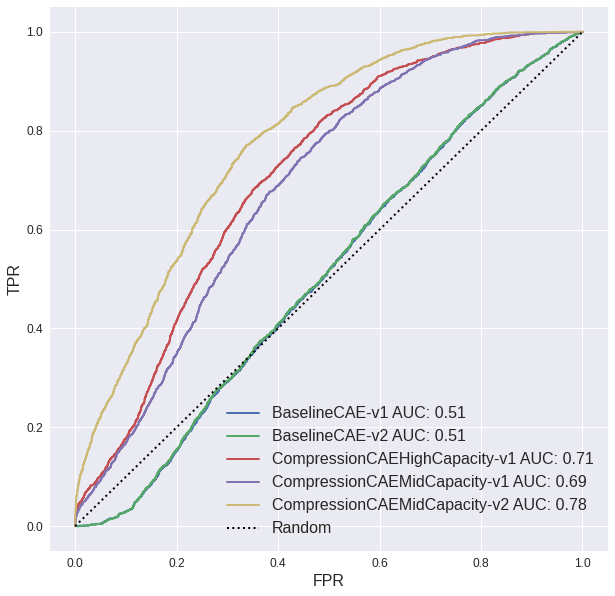

Random ROC AUC: 0.5


In [10]:
logging.getLogger().disabled = True
plt.figure(figsize=(10,10))
for col in scores:
    fpr, tpr, thresholds, auc = metrics.roc(scores[col], labels[col])

    plt.plot(fpr, tpr, lw=2., label=f'{col} AUC: {auc:.2f}')

    print(f'{col} ROC AUC: {auc}')
    
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.show()
print('Random ROC AUC: 0.5')

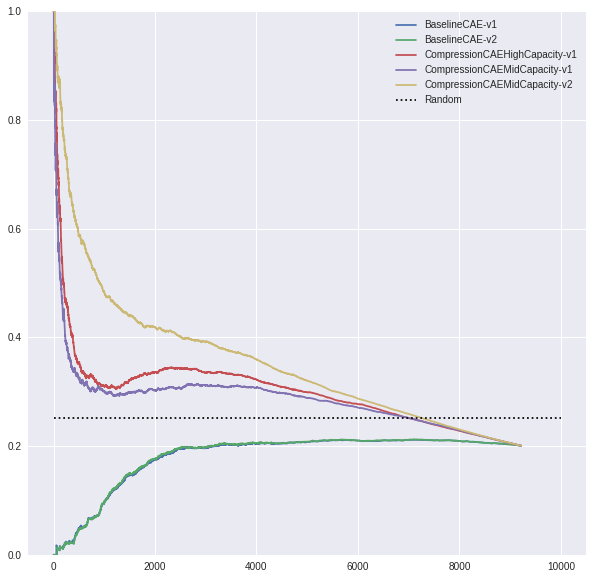

In [14]:
plt.figure(figsize=(10,10))
for col in scores:
    pak = metrics.precision_at_k(scores[col], labels[col])

    uniques, counts = np.unique(labels[col], return_counts=True)
    random = counts.min() / counts.max()

    plt.plot(pak, label=f'{col}')
    
plt.plot([0, 10000], [random, random], 'k:', label='Random')
plt.ylim([0., 1.])
plt.legend()
plt.show()

In [17]:
print(len(pak))

9216
